In [49]:
import tensorflow as tf
from tensorflow import keras
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys
from datetime import datetime
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt


## Transfer Learning with TensorFlow Part 2: Fine-tuning

In [5]:
# Create training and test directories
train_dir = "./data/data_multiclass_10/train/"
test_dir = "./data/data_multiclass_10/test/"

In [7]:
# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Model 0: Building a transfer learning model using the Keras Functional API

In [9]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 #callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")]
)

24274472/24274472 [==============================] - 15s 1us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Epoch 1/5


2024-02-29 18:11:16.673280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


 4/24 [====>.........................] - ETA: 0s - loss: 2.3713 - accuracy: 0.1172  

2024-02-29 18:11:18.165175: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f196159a300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 18:11:18.165190: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-29 18:11:18.170209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-29 18:11:18.233323: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 8s 91ms/step - loss: 1.8616 - accuracy: 0.4413 - val_loss: 1.3226 - val_accuracy: 0.7434
Epoch 2/5
24/24 [==============================] - 1s 42ms/step - loss: 1.1382 - accuracy: 0.7640 - val_loss: 0.8841 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 1s 39ms/step - loss: 0.8300 - accuracy: 0.8227 - val_loss: 0.7059 - val_accuracy: 0.8553
Epoch 4/5
24/24 [==============================] - 1s 43ms/step - loss: 0.6825 - accuracy: 0.8520 - val_loss: 0.6358 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 1s 43ms/step - loss: 0.5923 - accuracy: 0.8560 - val_loss: 0.5605 - val_accuracy: 0.8618


In [10]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [11]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

Our overall model has five layers but really, one of those layers (`efficientnetv2-b0`) has 269 layers.

You can see how the output shape started out as `(None, 224, 224, 3)` for the input layer (the shape of our images) but was transformed to be `(None, 10)` by the output layer (the shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?



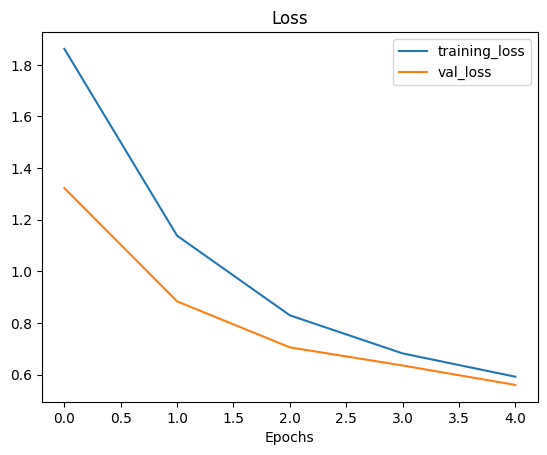

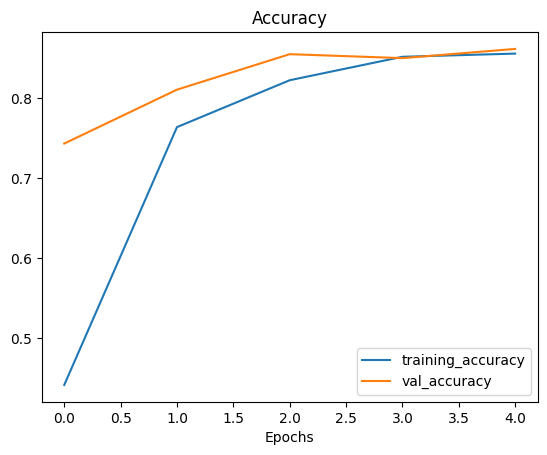

In [12]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

In [14]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [15]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same as the above cell but for [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

## Running a series of transfer learning experiments

1. **Model 1**: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. **Model 2**: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. **Model 3**: Fine-tune the **Model 2** checkpoint on 10% of the training data with data augmentation.
4. **Model 4**: Fine-tune the **Model 2** checkpoint on 100% of the training data with data augmentation.

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [25]:
# Create training and test directories
train_dir_10_percent = "./data/data_multiclass_10/train/"
test_dir_10_percent = "./data/data_multiclass_10/test/"

Data downloaded. Let's create the dataloaders.

In [26]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.


Found 2500 files belonging to 10 classes.


In [27]:
# Create a functional model with data augmentation
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.2),
  keras.layers.RandomZoom(0.2),
  keras.layers.RandomHeight(0.2),
  keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = keras.layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

In [28]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = keras.layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = keras.layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

model_2 = create_base_model()

In [29]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [30]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback]) # save model for each epoch

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240229-182333
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 2.0000 - accuracy: 0.3253
Epoch 1: val_loss improved from inf to 1.51748, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 309ms/step - loss: 2.0000 - accuracy: 0.3253 - val_loss: 1.5175 - val_accuracy: 0.5954
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4006 - accuracy: 0.6573
Epoch 2: val_loss improved from 1.51748 to 1.07277, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 226ms/step - loss: 1.4006 - accuracy: 0.6573 - val_loss: 1.0728 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1149 - accuracy: 0.7240
Epoch 3: val_loss improved from 1.07277 to 0.84949, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 242ms/step - loss: 1.1149 - accuracy: 0.7240 - val_loss: 0.849

In [31]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 2s 23ms/step - loss: 0.6560 - accuracy: 0.8364


[0.6559810638427734, 0.8363999724388123]

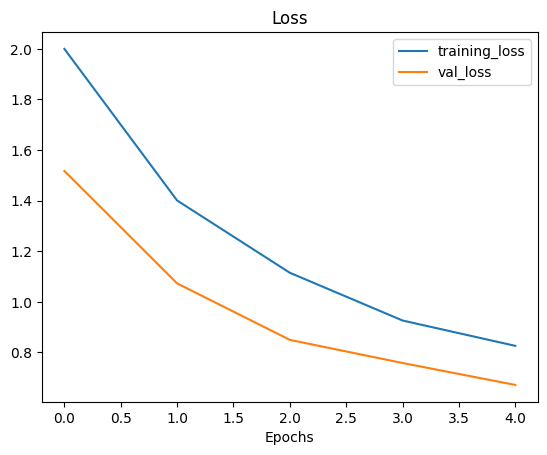

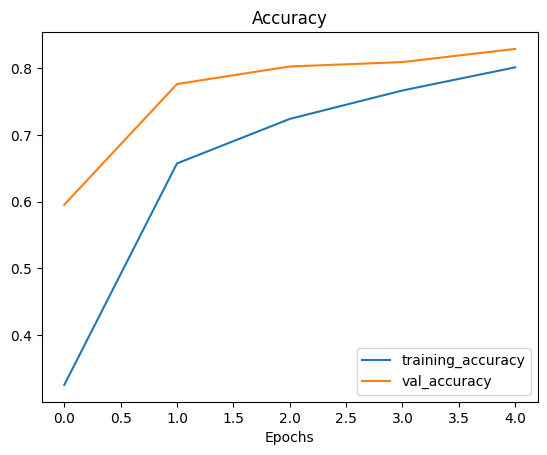

In [32]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [33]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 2s 22ms/step - loss: 0.6560 - accuracy: 0.8364


In [34]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

## Model 3: Fine-tuning an existing model on 10% of the data

In [38]:
# Layers in loaded model
model_2.layers

In [39]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7f1cc567c510> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7f1daa0b51d0> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7f1cc564d3d0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f1cc56ca190> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7f1cc5455d10> | Trainable? True


In [40]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [41]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [42]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


We can even check layer by layer to see if the they're trainable.

To access the layers in `model_2_base_model`, we can use the `layers` attribute.

In [43]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [44]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [45]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

Every time you make a change to your models, you need to recompile them.

In [46]:
print(len(model_2.trainable_variables))

12


Wonderful, it looks like our model has a total of 12 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [47]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent, epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240229-182904
Epoch 5/10
24/24 [==============================] - 19s 608ms/step - loss: 0.7078 - accuracy: 0.8120 - val_loss: 0.5412 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 9s 392ms/step - loss: 0.6047 - accuracy: 0.8107 - val_loss: 0.5113 - val_accuracy: 0.8388
Epoch 7/10
24/24 [==============================] - 9s 362ms/step - loss: 0.5725 - accuracy: 0.8267 - val_loss: 0.5168 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 7s 292ms/step - loss: 0.4949 - accuracy: 0.8280 - val_loss: 0.4655 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 8s 326ms/step - loss: 0.4719 - accuracy: 0.8640 - val_loss: 0.4635 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 7s 289ms/step - loss: 0.4198 - accuracy: 0.8640 - val_loss: 0.4733 - val_accuracy: 0.8405


In [48]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 2s 22ms/step - loss: 0.4308 - accuracy: 0.8560


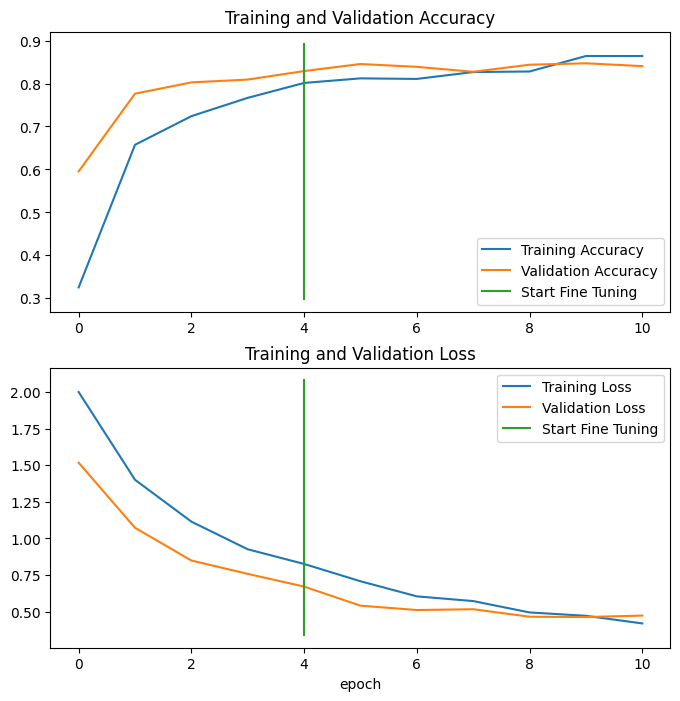

In [50]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

## Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [51]:
# Setup data directories
train_dir = "./data/data_multiclass_pizza_steak_other/train/"
test_dir = "./data/data_multiclass_pizza_steak_other/test/"

In [52]:
# Setup data inputs
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [53]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 2s 24ms/step - loss: 0.4308 - accuracy: 0.8560


[0.4308101534843445, 0.8560000061988831]

In [54]:
results_fine_tune_10_percent

[0.4308100938796997, 0.8560000061988831]

To keep our experiments clean, we'll load a create a new instance of `model_2` using our `create_base_model()` function.

More specifically, we're trying to measure:
* **Experiment 3 (previous one)** - `model_2` with 10 layers fine-tuned for 5 more epochs on 10% of the data.
* **Experiment 4 (this one)** - `model_2` with layers fined-tuned for 5 more epochs on 100% on the data.

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (`model_2` feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of `model_2`.

In [55]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

And now to make sure it starts at the same checkpoint, we can load the checkpointed weights from `checkpoint_path`.

In [56]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

Let's now get a summary and check how many trainable variables there are.

In [57]:
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [58]:
print(len(model_2.trainable_variables))

2


Nice! This is the same as our original checkpoint.

And the results should be the same as `results_10_percent_data_aug`.

In [59]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 3s 22ms/step - loss: 0.6560 - accuracy: 0.8364


[0.6559810638427734, 0.8363999724388123]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint` (**Model 2**).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (**Model 3**).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (**Model 4**).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [60]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


Remember, the `base_model` of `model_2` (`efficientnetv2-b0`) can be referenced by `model_2.layers[2]`.

So let's unfreeze the last 10 layers of the `base_model` to make them trainable (for fine-tuning).

In [61]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

Now let's make sure the right layers are trainable (we only want the last 10 to be trainable).

> **Note:** You could experiment which number of layers should be trainable here. Generally, the more data you have, the more layers that can be fine-tuned.

In [62]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Looking good! The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

Do you remember what it is?

I'll give you a hint. We just reloaded the weights to our model and what do we need to do every time we make a change to our models?

Recompile them!

This will be just as before.

In [63]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

Alright, time to fine-tune on all of the data!

In [64]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240229-183419
Epoch 5/10
235/235 [==============================] - 55s 214ms/step - loss: 0.7223 - accuracy: 0.7733 - val_loss: 0.3680 - val_accuracy: 0.8914
Epoch 6/10
235/235 [==============================] - 36s 153ms/step - loss: 0.5973 - accuracy: 0.8049 - val_loss: 0.3555 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 32s 137ms/step - loss: 0.5362 - accuracy: 0.8303 - val_loss: 0.3108 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - 29s 124ms/step - loss: 0.5048 - accuracy: 0.8363 - val_loss: 0.2991 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 28s 118ms/step - loss: 0.4730 - accuracy: 0.8491 - val_loss: 0.3227 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 25s 105ms/step - loss: 0.4600 - accuracy: 0.8527 - val_loss: 0.2704 - val_accuracy: 0.9079


In [65]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 2s 21ms/step - loss: 0.2590 - accuracy: 0.9088


[0.259010374546051, 0.9088000059127808]

In [66]:
results_fine_tune_10_percent

[0.4308100938796997, 0.8560000061988831]

Nice! It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look?

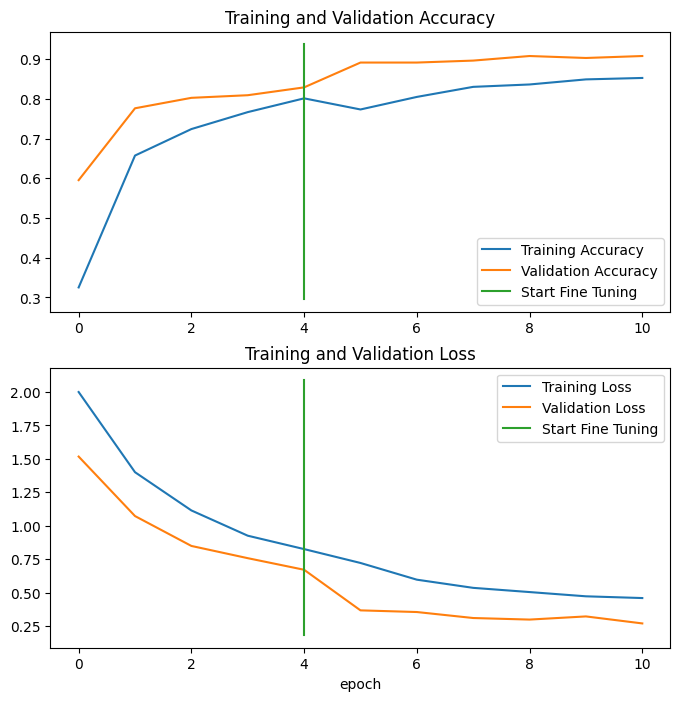

In [67]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)